# Preprocessing and labeling

In [1]:
import pandas as pd
import json

# Import json file
with open('dataset.json') as file:
    data = json.load(file)

# Convert json to pandas dataframe
df = pd.json_normalize(data)

# Split cuisines for double entries
df['cuisines_1'] = pd.json_normalize(pd.json_normalize(df['cuisines'])[0])['label']
df['cuisines_2'] = pd.json_normalize(pd.json_normalize(df['cuisines'])[1])['label']

# Select only relevant columns
df = df[['objectID', 'price_category.slug', 'cuisines_1', 'cuisines_2', 'more_details.full_images']].copy()

# Drop rows with missing values in price_category
df.dropna(subset=['price_category.slug'], inplace=True)

# Row for each image_id
df = df.explode('more_details.full_images')
df.reset_index(drop=True, inplace=True)
df['image_id'] = pd.json_normalize(df['more_details.full_images'])['image_id']
df = df[['objectID', 'image_id', 'price_category.slug', 'cuisines_1', 'cuisines_2']].copy()
df.rename(columns={'price_category.slug': 'price_category'}, inplace=True)


Filtering out low frequency cuisines

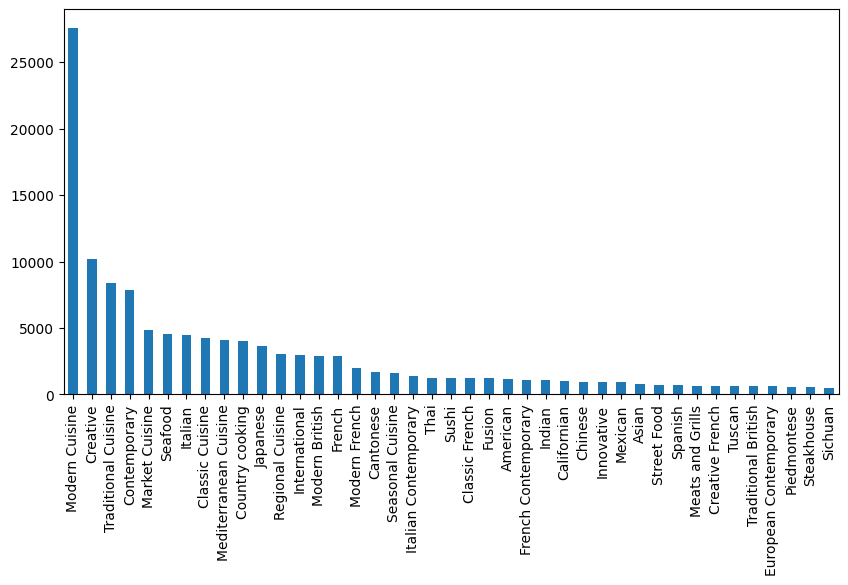

42


In [13]:
# List of all cuisines
cuisines = pd.concat([df['cuisines_1'], df['cuisines_2']])
cuisines.dropna(inplace=True)

# Plot cuisines with more than 500 entries
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
cuisines.value_counts()[cuisines.value_counts() > 500].plot(kind='bar')
plt.show()

# List all unique cuisines with more than 500 entries
top_cuisines = cuisines.value_counts()[cuisines.value_counts() > 500].index.tolist()

# Filter dataframe to only include top cuisines (or NaN for second cuisine if it's missing)
df = df[(df['cuisines_1'].isin(top_cuisines)) & ((df['cuisines_2'].isin(top_cuisines)) | (df['cuisines_2'].isna()))].copy()
df.reset_index(drop=True, inplace=True)

# Unique cuisine count
print(len(pd.concat([df['cuisines_1'], df['cuisines_2']]).unique()))


Export to csv

In [4]:
# Create csv
df.to_csv('labels.csv', index=False)